In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import warnings
import os
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from model.TICL import TICL
from data.Dataloader import CustomDataset


def test(model, test_dataloader, device, num_classes):
    model.eval()
    preds = []
    targets = []
    class_indices = np.arange(num_classes)
    indices_tensor = torch.tensor(class_indices)
    one_hot_tensors = F.one_hot(indices_tensor, num_classes=num_classes)
    top1_correct, top3_correct, top5_correct = 0, 0, 0
    top1_hour_correct = 0
    total = 0
    error = []
    with torch.no_grad():
        time_gallery = one_hot_tensors.to(device)
        for images, labels, hour in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.argmax(labels, 1)
            outputs = model(images, time_gallery.float())
            _, predicted = torch.topk(outputs, 5, 1)
            top1_predictions = predicted[:, 0]
            total += labels.size(0)
            top1_correct += (predicted[:, 0] == labels).sum().item()
            top3_correct += (predicted[:, :3] == labels.unsqueeze(1)).sum().item()
            top5_correct += (predicted == labels.unsqueeze(1)).sum().item()
            predicted_hour = top1_predictions.cpu().numpy() * (
                24 / num_classes
            ) + 0.5 * (24 / num_classes)
            batch_errors = np.abs(predicted_hour - hour.cpu().numpy())
            batch_errors = np.where(batch_errors > 12, 24 - batch_errors, batch_errors)
            top1_hour_correct += (batch_errors <= 0.5).sum().item()
            error.extend(batch_errors)
            preds.extend(top1_predictions.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    error = np.array(error)
    print(f"Top-1 Accuracy: {top1_correct / total}")
    print(f"Top-3 Accuracy: {top3_correct / total}")
    print(f"Top-5 Accuracy: {top5_correct / total}")
    print(error)
    print(f"Time MAE: {sum(error) / total * 60} minutes")
    return (
        top1_correct / total,
        top3_correct / total,
        top5_correct / total,
        sum(error) / total,
        preds, 
        targets
    )


def val(model, test_dataloader, device, num_classes=24):
    model.eval()
    preds = []
    targets = []
    class_indices = np.arange(num_classes)
    indices_tensor = torch.tensor(class_indices)
    one_hot_tensors = F.one_hot(indices_tensor, num_classes=num_classes)
    top1_correct, top3_correct, top5_correct = 0, 0, 0
    total = 0
    with torch.no_grad():
        time_gallery = one_hot_tensors.to(device)
        for images, labels, _ in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.argmax(labels, 1)
            outputs = model(images, time_gallery.float())
            _, predicted = torch.topk(outputs, 5, 1)
            top1_predictions = predicted[:, 0]
            total += labels.size(0)
            top1_correct += (predicted[:, 0] == labels).sum().item()
            top3_correct += (predicted[:, :3] == labels.unsqueeze(1)).sum().item()
            top5_correct += (predicted == labels.unsqueeze(1)).sum().item()
            preds.extend(top1_predictions)
            targets.extend(labels)
    print(f"Top-1 Accuracy: {top1_correct / total}")
    print(f"Top-3 Accuracy: {top3_correct / total}")
    print(f"Top-5 Accuracy: {top5_correct / total}")
    return top1_correct / total, top3_correct / total, top5_correct / total


def train(
    train_dataloader,
    eval_dataloader,
    model,
    optimizer,
    epoch,
    batch_size,
    device,
    scheduler=None,
    criterion=nn.CrossEntropyLoss(),
    num_classes=24,
):
    print("Starting Epoch", epoch)

    bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))

    targets_img_time = torch.Tensor([i for i in range(batch_size)]).long().to(device)

    for i, (imgs, labels, _) in bar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits_img_time = model(imgs, labels.float())
        img_gps_loss = criterion(logits_img_time, targets_img_time)
        loss = img_gps_loss
        loss.backward()
        optimizer.step()
        bar.set_description("Epoch {} loss: {:.5f}".format(epoch, loss.item()))
    a1, a2, a3 = val(model, eval_dataloader, device, num_classes=num_classes)
    with open(f"train_log_{num_classes}.txt", "a") as f:
        f.write(f"Epoch {epoch} Top-1: {a1} Top-3: {a2} Top-5: {a3}\n")
    if scheduler is not None:
        scheduler.step()
    return a1, a2, a3




    

2024-09-22 10:35:16.885622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 10:35:16.885651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 10:35:16.886167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 10:35:16.889475: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 10:35:17.458856: W tensorflow/compiler/tf2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
num_classes = 24
precomputed_train_path = "YOUR_PRECOMPUTED_TRAIN_FEATURE_PATH"
precomputed_test_path = "YOUR_PRECOMPUTED_TEST_FEATURE_PATH"
dataset_root = "YOUR_DATASET_PATH"
weight_decay = 1e-6
num_epochs = 20
lr = 0.0005
model = TICL(precomputed_image_feature=True, num_classes=num_classes).to(
    device
)
optimizer = optim.Adam(
    model.parameters(), lr=lr, weight_decay=weight_decay
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = CustomDataset(
    metadata_file=os.path.join(dataset_root, "train_metadata.json"),
    root_dir=os.path.join(dataset_root, "train"),
    transform=transform,
    pre_computed=precomputed_train_path,
    num_classes=num_classes,
)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

test_dataset = CustomDataset(
    metadata_file=os.path.join(dataset_root, 'test_metadata.json'),
    root_dir=os.path.join(dataset_root, 'test'),
    transform=transform,
    pre_computed= precomputed_test_path,
    num_classes=num_classes,
)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True
)

best_accuracy = 0
top1_acc_list, top3_acc_list, top5_acc_list = [], [], []

if os.path.exists(f"TICL_{num_classes}_adapter_v1_best.pth"):
    model.load_state_dict(
        torch.load(f"TICL_{num_classes}_adapter_v1_best.pth"), strict=False
    )
    print("Model loaded!")
else:
    print("Model not found!")
    print("Training the model...")
    with open(f"train_log_{num_classes}.txt", "w") as f:
        f.write("Training log\n")
        f.write(f"Batch size: {batch_size}\n")
        f.write(f"Number of classes: {num_classes}\n")
        f.write(f"Number of epochs: {num_epochs}\n")

    for epoch in range(num_epochs):
        top1_acc, top3_acc, top5_acc = train(
            train_dataloader,
            model,
            optimizer,
            epoch,
            batch_size,
                device,
                scheduler,
                num_classes=num_classes,
            )

        # save best model if accuracy is improved
        if top1_acc > best_accuracy:
            best_accuracy = top1_acc
            # save only the trainable parameters
            state_dict = model.state_dict()
            save_state_dict = {}
            for key in state_dict:
                # Filter out CLIP backbone parameters
                if "CLIP" not in key:
                    save_state_dict[key] = state_dict[key]
            torch.save(save_state_dict, f"TICL_{num_classes}_adapter_v1_best.pth")
        top1_acc_list.append(top1_acc)
        top3_acc_list.append(top3_acc)
        top5_acc_list.append(top5_acc)

top1_acc, top3_acc, top5_acc, time_mae, preds, targets = test(
    model, test_dataloader, device, num_classes=num_classes
)


/home/rath/anaconda3/envs/ece598/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be override

Pre-computed features are used.
Model loaded!


  0%|          | 0/25 [00:00<?, ?it/s]/home/rath/timeImage/Time_rep_release/model/TICL.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_features = torch.tensor(image).to(self.device)
100%|██████████| 25/25 [00:02<00:00, 10.88it/s]

Top-1 Accuracy: 0.20609375
Top-3 Accuracy: 0.49
Top-5 Accuracy: 0.6784375
[2.31666667 1.01666667 6.2        ... 0.8        0.03333333 0.9       ]
Time MAE: 170.8920312499998 minutes


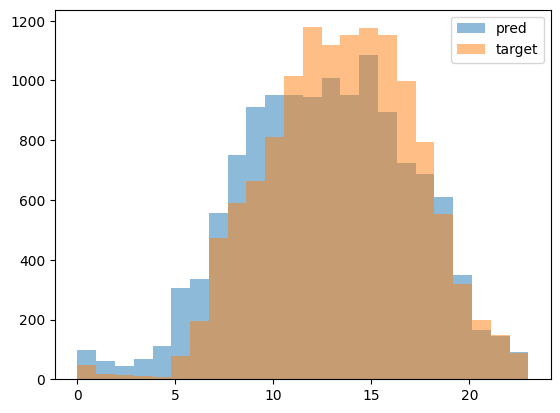

In [3]:
# visualize pred distribution
import matplotlib.pyplot as plt
# use a histogram to visualize the distribution of the predictions
preds_list = [p.item() for p in preds]
targets_list = [t.item() for t in targets]
plt.hist(preds_list, bins=num_classes, alpha=0.5, label='pred')
plt.hist(targets_list, bins=num_classes, alpha=0.5, label='target')
plt.legend(loc='upper right')
plt.show()

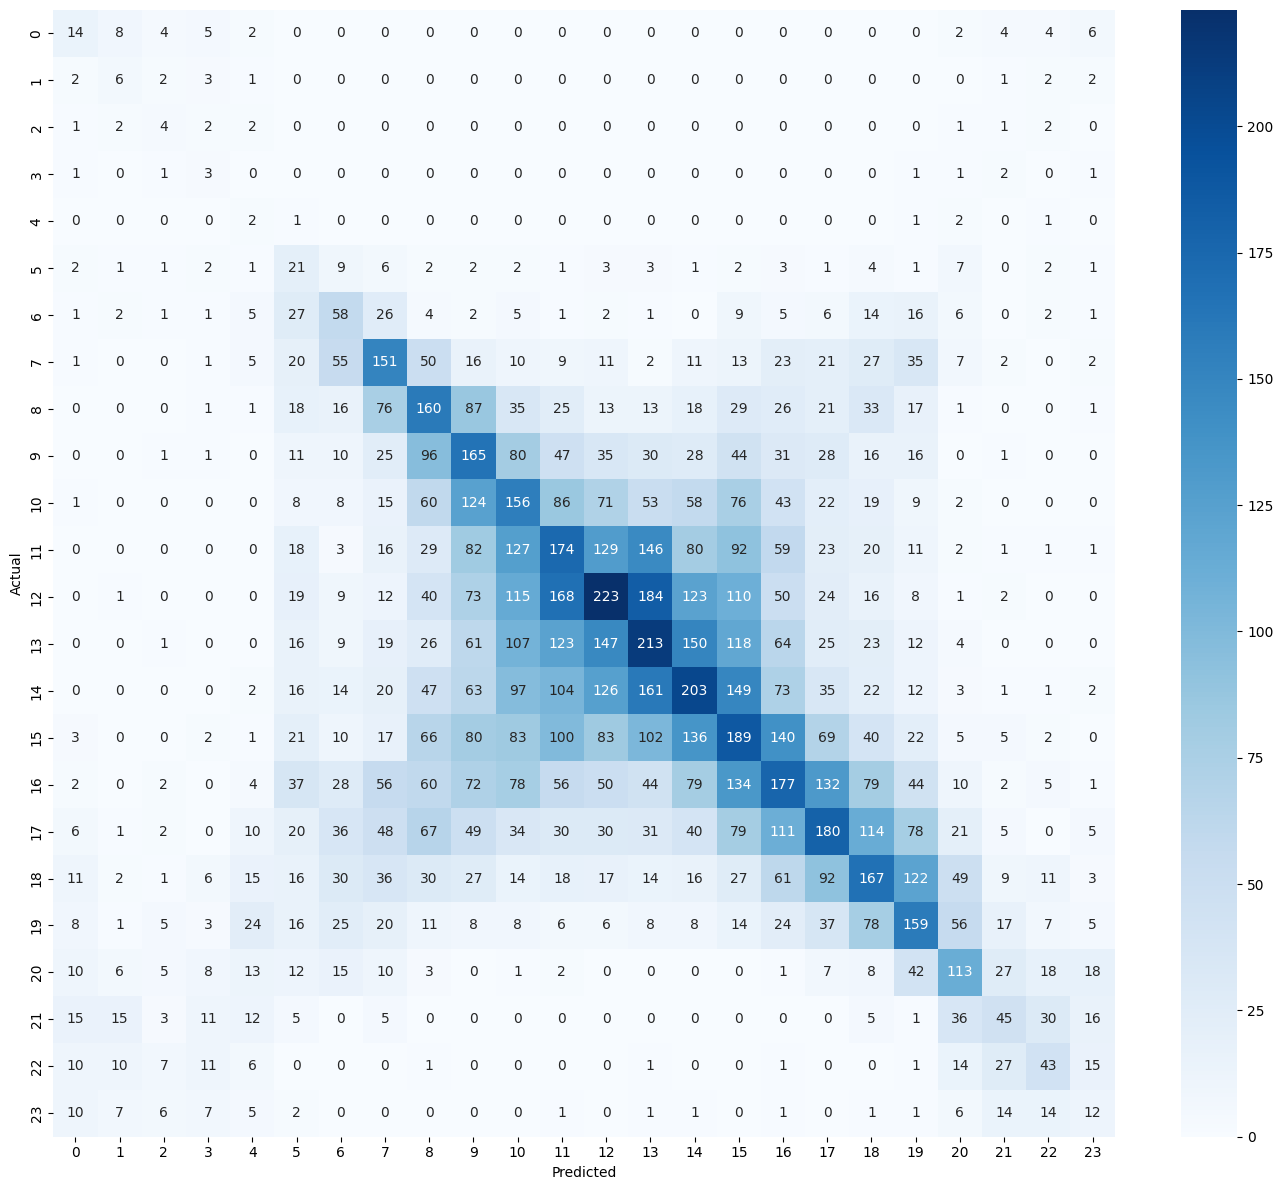

In [4]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(targets_list, preds_list)
num_samples = len(set(targets_list))
num_preds = len(set(preds_list))
df_cm = pd.DataFrame(cm, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])
plt.figure(figsize=(14, 12))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
# plt.savefig('confusion_matrix_hour_cascaded.svg')
plt.show()
plt.close()


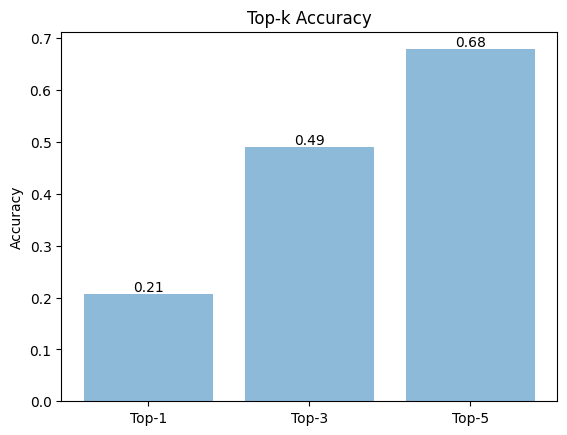

In [5]:
# visualize the top-k accuracy in the using a histogram
top_k_acc = [top1_acc, top3_acc, top5_acc]
top_k_acc_labels = ['Top-1', 'Top-3', 'Top-5']
plt.bar(top_k_acc_labels, top_k_acc, alpha=0.5)
# show the accuracy on top of the bars
for i, acc in enumerate(top_k_acc):
    plt.text(i, acc, str(round(acc, 2)), ha='center', va='bottom')
plt.ylabel('Accuracy')
plt.title('Top-k Accuracy')
plt.show()
plt.close()

/home/rath/timeImage/Time_rep_release/model/TICL.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_features = torch.tensor(image).to(self.device)


Top-1 prediction: 06:30 with probability: 0.2901689410209656
Top-2 prediction: 07:30 with probability: 0.28065696358680725
Top-3 prediction: 05:30 with probability: 0.15149851143360138
Top-4 prediction: 03:30 with probability: 0.043181076645851135
Top-5 prediction: 08:30 with probability: 0.03327314183115959


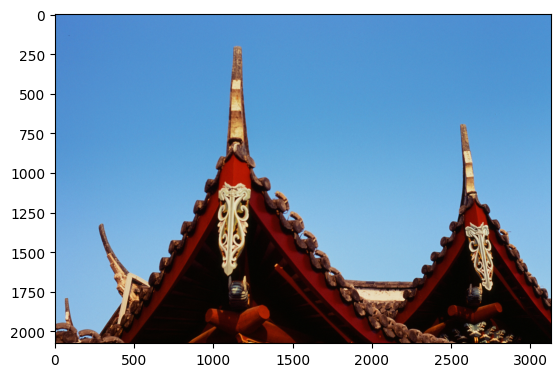

In [6]:
# predict for assets/demo.jpeg
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('assets/demo1.jpeg')
plt.imshow(img)

model.eval()
pred_time_str, top_pred_prob = model.predict('assets/demo1.jpeg', 5, 24)
# print(pred_time_str.shape)
# show the image
for i in range(5):
    print(f"Top-{i+1} prediction: {pred_time_str[i]} with probability: {top_pred_prob[i]}")


Top-1 prediction: 21:30 with probability: 0.21181359887123108
Top-2 prediction: 00:30 with probability: 0.1886308342218399
Top-3 prediction: 03:30 with probability: 0.14525827765464783
Top-4 prediction: 20:30 with probability: 0.10254058986902237
Top-5 prediction: 22:30 with probability: 0.08435018360614777


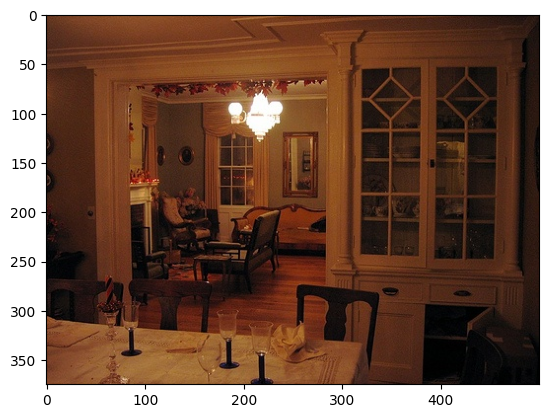

In [7]:

from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('assets/demo2.jpg')
plt.imshow(img)

model.eval()
pred_time_str, top_pred_prob = model.predict('assets/demo2.jpg', 5, 24)
# print(pred_time_str.shape)
# show the image
for i in range(5):
    print(f"Top-{i+1} prediction: {pred_time_str[i]} with probability: {top_pred_prob[i]}")


## Retrieval

In [ ]:
# compute features for all images in the webcam dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])
DATA_ROOT = 'YOUR_DATASET_PATH'
root_path = f'{DATA_ROOT}/toc/test/'
webcam_database = CustomDataset(metadata_file='./toc/test_database.json', root_dir='./toc/test', transform=transform)
webcam_dataloader = DataLoader(webcam_database, batch_size=1, shuffle=False, drop_last=False)
webcam_query = CustomDataset(metadata_file='./toc/query_toc.json', root_dir='./toc/test', transform=transform)
webcam_query_dataloader = DataLoader(webcam_query, batch_size=1, shuffle=False, drop_last=False)


In [ ]:
import torchvision
import torch
import torch.nn as nn
import numpy as np
import os
from tqdm import tqdm

feature_type = 'timeclip'

def compute_image_features_encoder(model, dataloader, device, batch_size=10000):
    features_list = []
    model.eval()
    model.to(device)
    count = 0
    part = 0

    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            feature = model(images)
            feature = feature.view(images.size(0), -1)  # Ensure the features are in (batch_size, 2048)
            features_list.append(feature.cpu().numpy())

            count += images.size(0)
            if count >= batch_size:
                np.savez(f'{root_path}webcam_database_features_part_{part}.npz', features=np.concatenate(features_list, axis=0))
                features_list = []
                count = 0
                part += 1

    if features_list:
        np.savez(f'{root_path}webcam_database_features_part_{part}.npz', features=np.concatenate(features_list, axis=0))

    # Merging all the saved parts
    all_features = []
    for i in range(part + 1):
        data = np.load(f'{root_path}webcam_database_features_part_{i}.npz')
        all_features.append(data['features'])

    all_features = np.concatenate(all_features, axis=0)
    return all_features

def compute_image_features(model, dataloader, device):
    features = []
    model.eval()
    model.to(device)
    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            feature = model.image_encoder(images)
            features.append(feature.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features



if feature_type == 'timeclip':
    model = TICL().to(device)
    model_path = 'BEST_MODEL_PATH'
    model.load_state_dict(torch.load(model_path))
    if not os.path.exists(f'{root_path}webcam_database_features.npy'):
        webcam_database_features = compute_image_features(model, webcam_dataloader, device)
        np.save(f'{root_path}webcam_database_features.npy', webcam_database_features)
    else:
        webcam_database_features = np.load(f'{root_path}webcam_database_features.npy')
print('webcam_database_features:', webcam_database_features.shape)


In [ ]:
import faiss
import torch
import torch.nn as nn
import torchvision
import numpy as np
import os
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import faiss
# import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import precision_recall_curve, average_precision_score
def build_faiss_index(features, metadata):
    index = faiss.IndexFlatL2(features.shape[1])
    index.add(features)
    return index, metadata
rerank = False
faiss_index, webcam_database_metadata = build_faiss_index(webcam_database_features, webcam_database.metadata)
faiss.write_index(faiss_index, 'webcam_database.index')
# 0-360
# we pick 0.01 as the threshold for the geo diff if geolocation aware retrieval is used
# if we do not care about the geolocation, we can set it to 360
GEO_DIFF_THRESHOLD = 360
# 0-24
TIME_DIFF_THRESHOLD = 0.5
# for each query image, count how many images in the database are within the threshold
def check_positive_rate(query_full_metadata, database_metadata):
    positive_rate = []
    for entry in tqdm(query_full_metadata):
        query_time = entry['time']
        query_geolocation = entry['latitude'], entry['longitude']
        query_time = query_time.split('.')[0]
        query_hour = datetime.strptime(query_time, "%Y-%m-%d %H:%M:%S").hour
        query_minute = datetime.strptime(query_time, "%Y-%m-%d %H:%M:%S").minute
        query_time_minute = query_hour * 60 + query_minute
        tp = 0
        for data in database_metadata:
            # check the time difference
            result_time = data['time']
            result_geolocation = data['latitude'], data['longitude']
            result_time = result_time.split('.')[0]
            result_hour = datetime.strptime(result_time, "%Y-%m-%d %H:%M:%S").hour
            result_minute = datetime.strptime(result_time, "%Y-%m-%d %H:%M:%S").minute
            result_time_minute = result_hour * 60 + result_minute
            time_diff = abs(query_time_minute - result_time_minute)
            time_diff = min(time_diff, 1440 - time_diff) / 60
            geo_diff = np.linalg.norm(np.array(query_geolocation) - np.array(result_geolocation))
            if time_diff < TIME_DIFF_THRESHOLD and geo_diff < GEO_DIFF_THRESHOLD:
                tp += 1
        positive_rate.append(tp)
    return positive_rate
 
def calculate_recall_rate_by_chance(positive_rate, num_query, k, num_database):
    recall_k = 0
    zero_count = positive_rate.count(0)
    # recall rate by chance = sum(individual recall rate by chance) / num_query
    for tp in positive_rate:
        if tp == 0:
            recall_k += 0
        else:
            recall_k += 1 - (1 - tp/num_database) ** k
    recall_k /= (num_query - zero_count)
    return recall_k

    
    
def search_faiss_index_and_evaluate(model, query_dataloader, faiss_index, database_metadata, device, top_k=100, threshold=0.5, feature_type='timeclip'):
    faiss_index = faiss.read_index('webcam_database.index')
    print('faiss_index:', faiss_index.ntotal)
    model.to(device)

    results = []
    similarities = []
    tp, fp, fn = 0, 0, 0
    R1_list, R3_list, R5_list, R10_list, R20_list = [], [], [], [], []
    time_diff_list = []
    geo_diff_list = []
    
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        # use idx to fetch each query image's metadata
        for idx, (images, _) in enumerate(tqdm(query_dataloader)):
            images = images.to(device)
            if feature_type == 'timeclip':
                features = model.image_encoder(images)
            features = features.cpu().numpy()
            D, I = faiss_index.search(features, top_k)
            results.append(I)
            similarities.append(D)
            query_time = query_dataloader.dataset.get_time(idx)
            query_geolocation = query_dataloader.dataset.get_geolocation(idx)
            query_time = query_time.split('.')[0]
            query_hour = datetime.strptime(query_time, "%Y-%m-%d %H:%M:%S").hour
            query_minute = datetime.strptime(query_time, "%Y-%m-%d %H:%M:%S").minute
            query_time_minute = query_hour * 60 + query_minute
            R1, R3, R5, R10, R20 = 0, 0, 0, 0, 0
            for i, result in enumerate(I[0]):
                result_time = database_metadata[result]['time']
                result_geolocation = database_metadata[result]['latitude'], database_metadata[result]['longitude']
                result_time = result_time.split('.')[0]
                
                result_hour = datetime.strptime(result_time, "%Y-%m-%d %H:%M:%S").hour
                result_minute = datetime.strptime(result_time, "%Y-%m-%d %H:%M:%S").minute
                result_time_minute = result_hour * 60 + result_minute
                time_diff = abs(query_time_minute - result_time_minute)
                time_diff = min(time_diff, 1440 - time_diff) / 60
                time_diff_list.append(time_diff)
                geo_diff = np.linalg.norm(np.array(query_geolocation) - np.array(result_geolocation))
                geo_diff_list.append(geo_diff)
                
                is_match = (time_diff <= threshold) and (geo_diff <= GEO_DIFF_THRESHOLD)
                if i < 1:
                    y_true.append(is_match)
                    y_scores.append(D[0][i])
    
                if is_match:
                    tp += 1
                    if i < 1:
                        R1 += 1
                    if i < 3:
                        R3 += 1
                    if i < 5:
                        R5 += 1
                    if i < 10:
                        R10 += 1
                    if i < 20:
                        R20 += 1
                else:
                    fp += 1
                    
                R1 = min(R1, 1)
                R3 = min(R3, 1)
                R5 = min(R5, 1)
                R10 = min(R10, 1)
                R20 = min(R20, 1)
                R1_list.append(R1)
                R3_list.append(R3)
                R5_list.append(R5)
                R10_list.append(R10)
                R20_list.append(R20)
    
    results = np.array(results).squeeze()
    
    Final_R1 = sum(R1_list) / len(R1_list)
    Final_R3 = sum(R3_list) / len(R3_list)
    Final_R5 = sum(R5_list) / len(R5_list)
    Final_R10 = sum(R10_list) / len(R10_list)
    Final_R20 = sum(R20_list) / len(R20_list)
    print(f'y_true: {len(y_true)}')
    print(f'y_scores: {len(y_scores)}')

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: AP={average_precision:.2f}')
    plt.show()

    return results, similarities, Final_R1, Final_R3, Final_R5, Final_R10, Final_R20, time_diff_list, geo_diff_list

results, similarities, R1, R3, R5, R10, R20, time_diff, geo_diff = search_faiss_index_and_evaluate(
    model, 
    webcam_query_dataloader, 
    faiss_index, 
    webcam_database_metadata, 
    device, 
    feature_type=feature_type, 
    threshold=TIME_DIFF_THRESHOLD, 
)

print(f'feature type: {feature_type}')
print(f'R@1: {R1}, R@3: {R3}, R@5: {R5}, R@10: {R10}, R@20: {R20}')
